# Blockchain introduction seminar

Based on: 
* https://github.com/santisiri/proof-of-work/blob/master/pow.py
* http://ecomunsing.com/build-your-own-blockchain
* https://github.com/JaeDukSeo/Simple-Merkle-Tree-in-Python
* https://www.laurentluce.com/posts/python-and-cryptography-with-pycrypto/

## 1. Proof-of-Work

Ниже приведена простая реализация функции Proof-of-Work.
Она принимает заголовок блока и сложность вычисления (количество битов, которые должны быть нулевыми в начале хэша) как параметры и возвращает итоговый хэш смайненного блока и nonce для этого блока.

In [1]:
import hashlib

def proof_of_work(header, difficulty_bits):
    max_nonce = 2 ** 32
    target = 2 ** (256-difficulty_bits)
    for nonce in range(max_nonce):
        hash_result = hashlib.sha256(str(header).encode('utf-8')+str(nonce).encode('utf-8')).hexdigest()

        if int(hash_result, 16) < target:
            return (hash_result, nonce)

Вычисляем корневой блок

In [5]:
import time

nonce = 0
block_hash = ""
header = 'This is the root block' + block_hash

difficulty_bits = 16

start_time = time.time()
(new_block, nonce) = proof_of_work(header, difficulty_bits)
end_time = time.time()
elapsed_time = end_time - start_time

print("Success with nonce ", nonce)
print("Hash is ", new_block)
print("Elapsed time: %.4f seconds" % elapsed_time)

Success with nonce  2719
Hash is  00000a951c4f8a88713ec38209093a852463fd07023b7c07b1d150bac521a9b3
Elapsed time: 0.0141 seconds


### Задание 1.1

Рассчитайте N=100 блоков для разного количества нулевых битов в начале хэша. Далее мы выведем логарифм затраченного времени и логарифм количества перебранных значений nonce как функцию от количества нулывых битов вначале. 

Какие мы ожидаем увидеть зависимости?

*Note.* Каждый следующий блок должен включать хэш предыдущего.

In [7]:
# code here

import numpy as np

number_of_blocks = 100

indexes_to_check = 16 #Максимальное количество нулей в начале блока
mean_times = np.zeros(indexes_to_check)

mean_nonce = np.zeros(indexes_to_check)

for current_difficulty in range(1, indexes_to_check + 1):
    print(current_difficulty)
    estimated_times = np.zeros(number_of_blocks)
    estimated_nonces = np.zeros(number_of_blocks)
    for block_number in range(number_of_blocks):
        start_time = time.time()
        # ==== TODO: let students fill this part
        (new_block, nonce) = proof_of_work(new_block, current_difficulty)
        # =====================================
        end_time = time.time()
        estimated_times[block_number] = end_time - start_time
        estimated_nonces[block_number] = nonce
        
    mean_times[current_difficulty-1] = np.mean(estimated_times)
    mean_nonce[current_difficulty-1] = np.mean(estimated_nonces)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


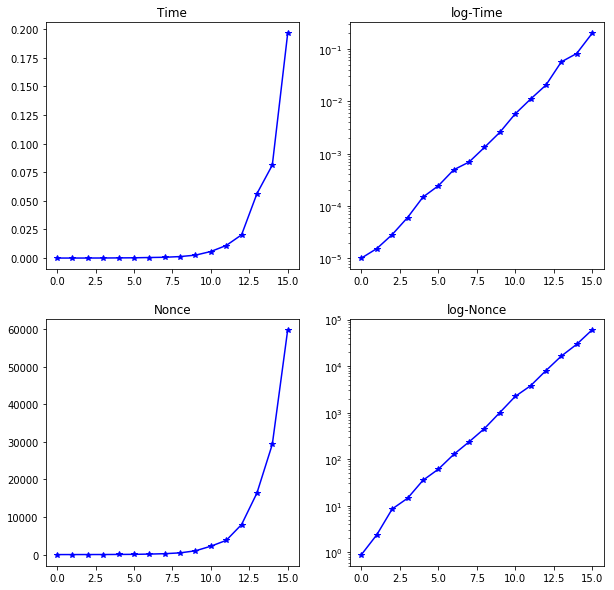

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

plt.subplot(221)

plt.title('Time')
plt.plot(range(indexes_to_check), mean_times, '-*b')

plt.subplot(222)
plt.title('log-Time')
plt.semilogy(range(indexes_to_check), mean_times, '-*b')

plt.subplot(223)
plt.title('Nonce')
plt.plot(range(indexes_to_check), mean_nonce, '-*b');
plt.subplot(224)
plt.title('log-Nonce')
plt.semilogy(range(indexes_to_check), mean_nonce, '-*b');

### Task 1.2

Измените функцию proof_of_work так, чтобы она принимала ограничение сверху на значение хэша(переменная target в нашей реализации) вместо количества нулевых битов вначале.

Какие разумные ограничения на это число?

Выберете такое значение, чтобы вычислять в среднем 20 160 000 блоков за каждые 14 дней. Докажите это эксперементально. (Вычислите время расчёта как минимум 2016 блоков и покажите, что это близко к целевому значению).

In [20]:
# code here

### Task 1.3 (Для энтузиастов)

Повторите эксперименты для других хэш-функций (к примеру, md5(), sha1(), sha224(), sha384(), и sha512()).

Какие вы видете изменения?

In [15]:
from hashlib import md5, sha1, sha224, sha384, sha512

In [16]:
# code here

## 2. Простая криптовалюта

Начнём с ведения счетов двух воображаемых людей: Алисы и Боба, которые будут торговать виртуальными деньгами друг с другом.
Нам необходимо создать пул входящих транзакций, провалидировать их, и собрать их в блок.
Будем использовать хэширование чтобы создать 'отпечаток' каждой из транзакций.

In [17]:
import hashlib, json, sys

def hashMe(msg=""):
    # For convenience, this is a helper function that wraps our hashing algorithm
    if type(msg)!=str:
        msg = json.dumps(msg,sort_keys=True)  # If we don't sort keys, we can't guarantee repeatability!
       
    return hashlib.sha256(str(msg).encode('utf-8')).hexdigest()

Ниже опишем функцию для генерации случайных обменов между Бобом и Алисой. Будем обозначать уход денег отрицательными числами, а приход - положительными. Определим, что транзакции будут всегда между двумя пользователями нашей системы, и убедимся, что сумма изменений счетов в транзакции равна нулю - то есть, что мы не создаём и не уничтожаем деньги.

In [19]:
import random

def generateTransaction(maxValue=3):
    # This will create valid transactions in the range of (1,maxValue)
    sign      = random.choice([-1,1])   # This will randomly choose -1 or 1
    amount    = random.randint(1,maxValue)
    aliceDiff = sign * amount
    bobDiff = -1 * aliceDiff
    # By construction, this will always return transactions that respect the conservation of tokens.
    # However, note that we have not done anything to check whether these overdraft an account
    return {u'Alice':aliceDiff,u'Bob':bobDiff}

Теперь сгенерируем список транзакций

In [43]:
random.seed(0)
txnBuffer = [generateTransaction() for i in range(30)]

Введём очень простые правила для нашей системы токенов:

* Сумма всех изменений счетов равна нулю (Мы не создаём и не уничтожаем токены)
* Счёт пользователя не может быть отрицательным ни в какой момент времени

Если хотябы одно из этих условий не будет выполнено, отменим транзакцию

*Note:* В реальных системах проверяется больше условий, в т.ч. электронная подпись участников транзакции

In [44]:
def updateState(txn, state):
    # Inputs: txn, state: dictionaries keyed with account names, holding numeric values for transfer amount (txn) or account balance (state)
    # Returns: Updated state, with additional users added to state if necessary
    # NOTE: This does not not validate the transaction- just updates the state!
    
    # If the transaction is valid, then update the state
    state = state.copy() # As dictionaries are mutable, let's avoid any confusion by creating a working copy of the data.
    for key in txn:
        if key in state.keys():
            state[key] += txn[key]
        else:
            state[key] = txn[key]
    return state

In [45]:
def isValidTxn(txn,old_state):
    # Assume that the transaction is a dictionary keyed by account names

    # Check that the sum of the deposits and withdrawals is 0
    if sum(txn.values()) is not 0:
        return False
    
    # Check that the transaction does not cause an overdraft
    for key in txn.keys():
        if key in old_state.keys(): 
            acctBalance = old_state[key]
        else:
            acctBalance = 0
        if (acctBalance + txn[key]) < 0:
            return False
    
    return True

Вот пример транзакций: некоторые из них нарушают правила, но теперь мы можем проверить их валидность!

In [46]:
state = {u'Alice':5,u'Bob':5}
print(isValidTxn({u'Alice': -3, u'Bob': 3},state))  # Basic transaction - this works great!
print(isValidTxn({u'Alice': -4, u'Bob': 3},state))  # But we can't create or destroy tokens!
print(isValidTxn({u'Alice': -6, u'Bob': 6},state))  # We also can't overdraft our account.
print(isValidTxn({u'Alice': -4, u'Bob': 2,'Lisa':2},state)) # Creating new users is valid
print(isValidTxn({u'Alice': -4, u'Bob': 3,'Lisa':2},state)) # But the same rules still apply!


True
False
False
True
False


### Строим блокчейн: От транзакций до блоков

In [50]:
state = {u'Alice':50, u'Bob':50}  # Define the initial state
genesisBlockTxns = [state]
genesisBlockContents = {
    u'blockNumber':0,
    u'parentHash':None,
    u'txnCount':len(genesisBlockTxns),
    u'txns':genesisBlockTxns
}
genesisHash = hashMe( genesisBlockContents )
genesisBlock = {u'hash':genesisHash,u'contents':genesisBlockContents}
genesisBlockStr = json.dumps(genesisBlock, sort_keys=True)

genesisBlockStr

'{"contents": {"blockNumber": 0, "parentHash": null, "txnCount": 1, "txns": [{"Alice": 50, "Bob": 50}]}, "hash": "7c88a4312054f89a2b73b04989cd9b9e1ae437e1048f89fbb4e18a08479de507"}'

In [51]:
chain = [genesisBlock]

In [52]:
def makeBlock(txns,chain):
    parentBlock = chain[-1]
    parentHash  = parentBlock[u'hash']
    blockNumber = parentBlock[u'contents'][u'blockNumber'] + 1
    txnCount    = len(txns)
    blockContents = {
        u'blockNumber':blockNumber,
        u'parentHash':parentHash,
        u'txnCount':len(txns),
        'txns':txns
    }
    blockHash = hashMe( blockContents )
    block = {u'hash':blockHash,u'contents':blockContents}
    
    return block

Используем описанную выше функцию, чтобы превратить наш буфер транзакций во множество блоков:

In [53]:
blockSizeLimit = 5  # Arbitrary number of transactions per block- 
               #  this is chosen by the block miner, and can vary between blocks!

while len(txnBuffer) > 0:
    bufferStartSize = len(txnBuffer)
    
    ## Gather a set of valid transactions for inclusion
    txnList = []
    while (len(txnBuffer) > 0) & (len(txnList) < blockSizeLimit):
        newTxn = txnBuffer.pop()
        validTxn = isValidTxn(newTxn,state) # This will return False if txn is invalid
        
        if validTxn:           # If we got a valid state, not 'False'
            txnList.append(newTxn)
            state = updateState(newTxn,state)
        else:
            print("ignored transaction")
            sys.stdout.flush()
            continue  # This was an invalid transaction; ignore it and move on
        
    ## Make a block
    myBlock = makeBlock(txnList,chain)
    chain.append(myBlock)  

In [54]:
chain[0]

{'contents': {'blockNumber': 0,
  'parentHash': None,
  'txnCount': 1,
  'txns': [{'Alice': 50, 'Bob': 50}]},
 'hash': '7c88a4312054f89a2b73b04989cd9b9e1ae437e1048f89fbb4e18a08479de507'}

In [55]:
chain[1]

{'contents': {'blockNumber': 1,
  'parentHash': '7c88a4312054f89a2b73b04989cd9b9e1ae437e1048f89fbb4e18a08479de507',
  'txnCount': 5,
  'txns': [{'Alice': 1, 'Bob': -1},
   {'Alice': -2, 'Bob': 2},
   {'Alice': 1, 'Bob': -1},
   {'Alice': -3, 'Bob': 3},
   {'Alice': -1, 'Bob': 1}]},
 'hash': '763b13ebd6e28eda4951d3140c81e0989389de5b48ae6de677d0cb223eeea664'}

In [56]:
print(len(chain))

7


Как видно, корневой блок включает невалидную транзакцию, которая задаёт начальное состояние счетов (создавая токены из ничего). Хэш родительского блока указан в блоке-потомке, который содержит список новых транзакций, изменяющий состояние системы. Теперь посмотрим на обновлённое состояние системы:

In [57]:
state

{'Alice': 44, 'Bob': 56}

### Checking Chain Validity

In [58]:
def checkBlockHash(block):
    # Raise an exception if the hash does not match the block contents
    expectedHash = hashMe( block['contents'] )
    if block['hash']!=expectedHash:
        raise Exception('Hash does not match contents of block %s'%
                        block['contents']['blockNumber'])
    return

In [59]:
def checkBlockValidity(block,parent,state):    
    # We want to check the following conditions:
    # - Each of the transactions are valid updates to the system state
    # - Block hash is valid for the block contents
    # - Block number increments the parent block number by 1
    # - Accurately references the parent block's hash
    parentNumber = parent['contents']['blockNumber']
    parentHash   = parent['hash']
    blockNumber  = block['contents']['blockNumber']
    
    # Check transaction validity; throw an error if an invalid transaction was found.
    for txn in block['contents']['txns']:
        if isValidTxn(txn,state):
            state = updateState(txn,state)
        else:
            raise Exception('Invalid transaction in block %s: %s'%(blockNumber,txn))

    checkBlockHash(block) # Check hash integrity; raises error if inaccurate

    if blockNumber!=(parentNumber+1):
        raise Exception('Hash does not match contents of block %s'%blockNumber)

    if block['contents']['parentHash'] != parentHash:
        raise Exception('Parent hash not accurate at block %s'%blockNumber)
    
    return state

In [60]:
def checkChain(chain):
    # Work through the chain from the genesis block (which gets special treatment), 
    #  checking that all transactions are internally valid,
    #    that the transactions do not cause an overdraft,
    #    and that the blocks are linked by their hashes.
    # This returns the state as a dictionary of accounts and balances,
    #   or returns False if an error was detected

    
    ## Data input processing: Make sure that our chain is a list of dicts
    if type(chain)==str:
        try:
            chain = json.loads(chain)
            assert( type(chain)==list)
        except:  # This is a catch-all, admittedly crude
            return False
    elif type(chain)!=list:
        return False
    
    state = {}
    ## Prime the pump by checking the genesis block
    # We want to check the following conditions:
    # - Each of the transactions are valid updates to the system state
    # - Block hash is valid for the block contents

    for txn in chain[0]['contents']['txns']:
        state = updateState(txn,state)
    checkBlockHash(chain[0])
    parent = chain[0]
    
    ## Checking subsequent blocks: These additionally need to check
    #    - the reference to the parent block's hash
    #    - the validity of the block number
    for block in chain[1:]:
        state = checkBlockValidity(block,parent,state)
        parent = block
        
    return state

Теперь мы можем проверить валидность нашего блокчейна (если он валиден, то функция вернёт итоговое состояние счетов, иначе - будет выброшено исключение):

In [65]:
checkChain(chain)

{'Alice': 44, 'Bob': 56}

И даже если мы сохраним куда-либо наш блокчейн, мы можем проверить целостность цепочки и узнать текущее состояние:

In [66]:
chainAsText = json.dumps(chain,sort_keys=True)
checkChain(chainAsText)

{'Alice': 44, 'Bob': 56}

Если мы удалим блок из цепи, она станет не валидной:

In [71]:
import copy

cropped_chain = copy.copy(chain)
cropped_chain.remove(cropped_chain[2])

checkChain(cropped_chain)

Exception: Hash does not match contents of block 3

Если мы изменим блок в цепи, то проверка тоже это выявит:

In [74]:
changedChain = copy.copy(chain)
changedChain[2][u'contents'][u'txns'].append({u'Alice': 1, u'Bob': -1})
checkChain(changedChain)

Exception: Hash does not match contents of block 2

### Задание 2.1

Добавьте Proof-of-Work в блокчейн и nonce в заголовок блока.

### Задание 2.2

Добавьте в транзакцию поля nonce (количество транзакций аккаунта за всю историю блокчейна) для каждого аккаунта, являющегося её участником, и измените функцию проверки транзакций, чтобы избежать повторения транзакций и чётко понимать, в каком порядке должны происходить транзакции.

Правило: Транзакция валидна, если поле nonce для каждого аккаунта, участвующего в транзакции, равно увеличенному на 1 полю nonce этого аккаунта в состоянии системы до проведения транзакции.

## Криптография с использованием публичных ключей

In [82]:
from Crypto import Random
from Crypto.Hash import MD5
from Crypto.PublicKey import RSA
random_generator = Random.new().read
key = RSA.generate(1024, random_generator)
print(key)

<_RSAobj @0x7f82a70a2748 n(1024),e,d,p,q,u,private>


In [83]:
print(key.can_encrypt())
print(key.can_sign())
print(key.has_private())

True
True
True


### Шифрование

In [84]:
public_key = key.publickey()
enc_data = public_key.encrypt(str('abcdefgh').encode('utf-8'), 32)
print(enc_data)

(b'\x16\xcd\xfe\x1dop\xd6D\x01v\x8cJ\xa5\x95C\x81\xef\x95\xbc\xad\xb7\xba\xb9\xb2\x18-\x19\x07j`\x87^5\xdf\xeb\xb2\xba\xa2\x05\xf6O\xa4\tA-\xcbG\x13\xb7*\xf72\xc4\x00r=b\x96\x05\xa5\x8f\xb3N"xG\x8b\xcf\xeeC\x9ao`\xa9\xe0#U\x158\xa5t\x041D;\\l\x0eEP\xa0\xb3|-\xaf\xba\xfa\x9b\xc8\xe7\xca\x0b\xb5\x19m\xf4\xf15\xd2\x05M\x8e\x1a\xedT(\x8c\x1a\xa7\x06\xa7jN\x83\xc4E\xdb2',)


### Дешифрование

In [85]:
key.decrypt(enc_data)

b'abcdefgh'

### Подпись

In [89]:
from Crypto.Hash import MD5
from Crypto.PublicKey import RSA
RSAkey = RSA.generate(1024, random_generator)   # This will take a while...
text = 'abcdefgh'
plaintext = str(text).encode('utf-8')
hash = MD5.new(plaintext).digest()
signature = RSAkey.sign(hash, "")
print(signature)

(106949245320726170266444009469730957851544882913212150247800145422467289802520859289644872306685173901921622609337848035900958896352886071317864739467256574450742986613761343982587617812762617046485733851064912938921916482160526799962295720477543140277383114748918615294355089577021210573512247839053478864208,)


### Верификация подписи

In [96]:
public_key = RSAkey.publickey()

print(public_key.verify(hash, signature))     # This sig will check out
print(public_key.verify(hash[:-1], signature)) # This sig will fail

True
False


Нельзя подписать публичным ключем

In [98]:
public_key.sign(hash, "")

TypeError: Private key not available in this object

### Задание 4.1

Добавьте подписи сторон к каждой транзакции и их проверку в isValidTxn.

### Задание 4.2

Продемонстрируйте итоговый блокчейн.